In [16]:
# this model includes ql
# it uses instantaneous bedrock erosion rate to calc ql
# it uses gamma to represent fraction of plucked material that becomes coarse gravel
# it uses theta to represent fraction of hillslope material that enters fluvial system as coarse 
## (maybe this should be same as gamma, 
## since the real fxn of this parameter is to tell us 
## how much coarse stuff is available for bedload transport/abrasion)

# potential updates: see if adding weighted average back in to ql calculation still allows for stability
## update on the update: this led to stability issues, and it's not worth the time now trying to debug, 
## so just stick with using instantaneous erosion rate. 
## Most interested in steady state profiles anyway, so this is fine.

In [17]:
import numpy as np
import matplotlib.pyplot as plt

In [18]:
# create a profile
dx = 500
x = np.arange(0, 50000, dx)
x_node = x + (dx/2)

# add some elevation
Hstar = 0.5 # depth decay
etab = np.zeros(len(x)) # bedrock elevation
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x)) # alluvium thickness
eta = etab + H # topography

In [19]:
# define constants and other parameters
K = 1e-7 # erodibility
beta = 0.0005 # abradability
r = 5. # runoff rate
U = 0.0001 # uplift or baselevel fall rate
I = 0.01 # intermittency
phi = 0.1 # porosity
D = 0.01 # grain size
gamma = 0.5 # fraction plucked that becomes coarse

kqs = 0.041 # sed transport coeff
kxb = 25 # valley width coeff
Pxb = 1./5. # valley width exp
kb = 8.3e-8 # channel width coeff

B_valley = kxb * (x_node**Pxb) # valley width
# Q = (r * kxb * x_node**(1 + Pxb))/(1 + Pxb) # discharge
A = (1./3.) * (x**2)
Q = r * A

In [20]:
def model(x, dx, x_node,
          K, beta, gamma,
          D, phi, Hstar,
          kb, kqs, I, r, U,
          etab, H, eta,
          B_valley, Q,
          num_steps = 1):
    
    q = Q/B_valley
    dt = 50
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p = np.zeros(len(x))
    Eb_a = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    ql = np.zeros(len(x)) # lateral sediment supply
    
    H[-1] = 0
    E[-1] = U
    q[0] = 0
    Qs[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= U * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1])
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p[:-1] = K * Q[1:] * S**(7./6.) * alpha[:-1] * I
        Eb_a[:-1] = beta * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B_valley[:-1]
        
        # calc lateral flux
        ql[:-1] = ((Eb[:-1] * gamma)/beta) * (1 - np.exp(-beta * x[1:]/3))
        
        # calc grain attrition
        atr = Qs * beta
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - (Eb_p[:-1]*gamma) - ql[:-1])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta)

In [21]:
#now write a test
num_steps = 1000000000

test_run = [x, dx, x_node, 
            K, beta, gamma,
            D, phi, Hstar,
            kb, kqs, I, r, U,
            etab, H, eta,
            B_valley, Q,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta) = model(*test_run)

50000000000.0


In [22]:
Eb

array([1.47702373e-04, 2.08602529e-05, 1.21026839e-04, 9.87384534e-05,
       1.00039858e-04, 9.99993634e-05, 9.99999838e-05, 1.00000000e-04,
       9.99999990e-05, 9.99999992e-05, 9.99999991e-05, 9.99999990e-05,
       9.99999990e-05, 9.99999990e-05, 9.99999989e-05, 9.99999989e-05,
       9.99999990e-05, 9.99999989e-05, 9.99999990e-05, 9.99999989e-05,
       9.99999989e-05, 9.99999989e-05, 9.99999990e-05, 9.99999989e-05,
       9.99999989e-05, 9.99999990e-05, 9.99999989e-05, 9.99999989e-05,
       9.99999989e-05, 9.99999989e-05, 9.99999990e-05, 9.99999989e-05,
       9.99999989e-05, 9.99999989e-05, 9.99999988e-05, 9.99999990e-05,
       9.99999988e-05, 9.99999989e-05, 9.99999990e-05, 9.99999989e-05,
       9.99999990e-05, 9.99999988e-05, 9.99999990e-05, 9.99999987e-05,
       9.99999991e-05, 9.99999988e-05, 9.99999990e-05, 9.99999989e-05,
       9.99999988e-05, 9.99999988e-05, 9.99999989e-05, 9.99999990e-05,
       9.99999989e-05, 9.99999988e-05, 9.99999990e-05, 9.99999988e-05,
      

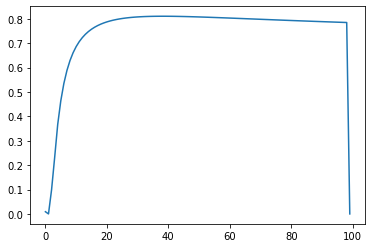

In [23]:
plt.plot(1 - alpha)

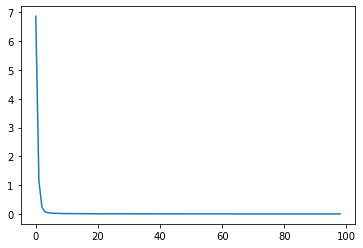

In [24]:
plt.plot(S)

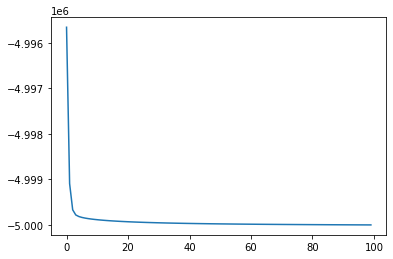

In [25]:
plt.plot(eta)

In [26]:
S[-1]

0.0005346567276865244

In [27]:
eta

array([-4995659.99313546, -4999093.44558541, -4999668.04780447,
       -4999780.34441829, -4999814.98483519, -4999834.91559941,
       -4999849.17936648, -4999860.4568094 , -4999869.86844636,
       -4999877.98393047, -4999885.13281923, -4999891.52425255,
       -4999897.30051491, -4999902.56376585, -4999907.39054091,
       -4999911.84015957, -4999915.95987447, -4999919.78817346,
       -4999923.35698234, -4999926.69318533, -4999929.81970664,
       -4999932.75630028, -4999935.5201406 , -4999938.12627294,
       -4999940.58796407, -4999942.91697906, -4999945.12380333,
       -4999947.21782304, -4999949.20747327, -4999951.10036109,
       -4999952.90336866, -4999954.62274031, -4999956.2641567 ,
       -4999957.83279827, -4999959.33339997, -4999960.77029869,
       -4999962.14747448, -4999963.46858669, -4999964.73700564,
       -4999965.95584055, -4999967.12796423, -4999968.256035  ,
       -4999969.34251615, -4999970.3896934 , -4999971.39969037,
       -4999972.37448257, -4999973.31590

In [28]:
eta_adj = eta - eta[-1]

In [29]:
eta_adj

array([4.33931944e+03, 9.05866994e+02, 3.31264775e+02, 2.18968161e+02,
       1.84327744e+02, 1.64396980e+02, 1.50133213e+02, 1.38855770e+02,
       1.29444133e+02, 1.21328649e+02, 1.14179760e+02, 1.07788327e+02,
       1.02012064e+02, 9.67488135e+01, 9.19220384e+01, 8.74724198e+01,
       8.33527049e+01, 7.95244059e+01, 7.59555970e+01, 7.26193940e+01,
       6.94928727e+01, 6.65562791e+01, 6.37924387e+01, 6.11863064e+01,
       5.87246153e+01, 5.63956003e+01, 5.41887760e+01, 5.20947563e+01,
       5.01051061e+01, 4.82122183e+01, 4.64092107e+01, 4.46898390e+01,
       4.30484226e+01, 4.14797811e+01, 3.99791794e+01, 3.85422807e+01,
       3.71651049e+01, 3.58439927e+01, 3.45755737e+01, 3.33567388e+01,
       3.21846151e+01, 3.10565444e+01, 2.99700632e+01, 2.89228859e+01,
       2.79128890e+01, 2.69380968e+01, 2.59966694e+01, 2.50868913e+01,
       2.42071610e+01, 2.33559819e+01, 2.25319542e+01, 2.17337671e+01,
       2.09601918e+01, 2.02100756e+01, 1.94823363e+01, 1.87759564e+01,
      

In [31]:
# save csv files

np.savetxt('elevation csv files/eta_exp_1.csv', eta_adj, delimiter = ',')
np.savetxt('alpha csv files/alpha_exp_1.csv', alpha, delimiter = ',')
np.savetxt('slope csv files/slope_exp_1.csv', S, delimiter = ',')